**Step 1: Spark Setup**

**Goal**: Set up Apache Spark in Google Colab using PySpark so we can process large datasets in a distributed fashion.

In [2]:
# 1. Install Java & Spark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xzf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark

# 2. Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

# 3. Initialize findspark and start Spark session
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Retail Sales Analytics") \
    .getOrCreate()

spark

**Step 2: Load Sample Retail Dataset**

**Goal**: Create and load a small retail transaction dataset for testing. This will simulate real-world sales data across multiple stores.

In [3]:
import pandas as pd

# Sample retail sales data
data = {
    "TransactionID": [1, 2, 3, 4, 5, 6, 7],
    "StoreID": [101, 101, 102, 103, 101, 102, 103],
    "Product": ["A", "B", "A", "C", "B", "A", "C"],
    "Quantity": [5, 3, 2, 7, 1, 4, 2],
    "Price": [100, 200, 100, 150, 200, 100, 150],
    "TransactionDate": [
        "2024-01-10", "2024-01-15", "2024-02-01", "2024-02-05",
        "2024-03-12", "2024-03-15", "2024-03-20"
    ]
}

# Convert to DataFrame and save as CSV
df = pd.DataFrame(data)
df.to_csv("/content/retail_data.csv", index=False)

**Step 3: Read the CSV with PySpark**

**Goal**: Read the CSV file into a Spark DataFrame, enabling efficient distributed processing and transformations.

In [4]:
from pyspark.sql.functions import col, to_date

# Load CSV using Spark
retail_df = spark.read.csv("/content/retail_data.csv", header=True, inferSchema=True)

# Convert TransactionDate to date type
retail_df = retail_df.withColumn("TransactionDate", to_date(col("TransactionDate"), "yyyy-MM-dd"))

# Show sample rows
retail_df.show()

+-------------+-------+-------+--------+-----+---------------+
|TransactionID|StoreID|Product|Quantity|Price|TransactionDate|
+-------------+-------+-------+--------+-----+---------------+
|            1|    101|      A|       5|  100|     2024-01-10|
|            2|    101|      B|       3|  200|     2024-01-15|
|            3|    102|      A|       2|  100|     2024-02-01|
|            4|    103|      C|       7|  150|     2024-02-05|
|            5|    101|      B|       1|  200|     2024-03-12|
|            6|    102|      A|       4|  100|     2024-03-15|
|            7|    103|      C|       2|  150|     2024-03-20|
+-------------+-------+-------+--------+-----+---------------+



**Step 4: Data Cleaning & Preparation**

**Goal**: Prepare the data for analysis by:

*   	Ensuring correct data types (e.g., converting TransactionDate to DateType)

*   	Creating a new column TotalAmount (Quantity × Price)

*   	Checking for and removing any null values to avoid downstream errors




In [8]:
from pyspark.sql.functions import col, to_date, isnan, isnull, expr

# 1. Convert 'TransactionDate' to DateType
retail_df = retail_df.withColumn("TransactionDate", to_date(col("TransactionDate"), "yyyy-MM-dd"))

# 2. Create 'TotalAmount' = Quantity * Price
retail_df = retail_df.withColumn("TotalAmount", expr("Quantity * Price"))

# 3. Identify numeric and non-numeric columns
numeric_cols = [field.name for field in retail_df.schema.fields if field.dataType.typeName() in ['double', 'integer', 'float', 'long']]
non_numeric_cols = [field.name for field in retail_df.schema.fields if field.name not in numeric_cols]

# 4. Check for nulls or NaNs
null_exprs = [isnull(col(c)).alias(c) for c in non_numeric_cols] + \
             [(isnull(col(c)) | isnan(col(c))).alias(c) for c in numeric_cols]

print("Null or NaN check for each column:")
retail_df.select(null_exprs).show()

# 5. Drop rows with any missing values
retail_df_clean = retail_df.dropna()

# 6. View cleaned data
retail_df_clean.show(5)

Null or NaN check for each column:
+-------+---------------+-------------+-------+--------+-----+-----------+
|Product|TransactionDate|TransactionID|StoreID|Quantity|Price|TotalAmount|
+-------+---------------+-------------+-------+--------+-----+-----------+
|  false|          false|        false|  false|   false|false|      false|
|  false|          false|        false|  false|   false|false|      false|
|  false|          false|        false|  false|   false|false|      false|
|  false|          false|        false|  false|   false|false|      false|
|  false|          false|        false|  false|   false|false|      false|
|  false|          false|        false|  false|   false|false|      false|
|  false|          false|        false|  false|   false|false|      false|
+-------+---------------+-------------+-------+--------+-----+-----------+

+-------------+-------+-------+--------+-----+---------------+-----------+
|TransactionID|StoreID|Product|Quantity|Price|TransactionDate|To

**Step 5: KPI 1 – Total Sales Per Store**

**Goal**: Calculate the total revenue generated by each store. This helps understand store-level performance.

In [9]:
# Total Sales per Store
store_sales = retail_df.groupBy("StoreID") \
                       .sum("TotalAmount") \
                       .withColumnRenamed("sum(TotalAmount)", "TotalSales")

store_sales.show()

+-------+----------+
|StoreID|TotalSales|
+-------+----------+
|    101|      1300|
|    103|      1350|
|    102|       600|
+-------+----------+



**Step 6: KPI 2 – Monthly Sales Trend**

**Goal**: Analyze how sales fluctuate month-over-month to identify seasonal trends or promotional impact.

In [10]:
from pyspark.sql.functions import month

monthly_sales = retail_df.withColumn("Month", month("TransactionDate")) \
                         .groupBy("Month") \
                         .sum("TotalAmount") \
                         .withColumnRenamed("sum(TotalAmount)", "MonthlySales") \
                         .orderBy("Month")

monthly_sales.show()

+-----+------------+
|Month|MonthlySales|
+-----+------------+
|    1|        1100|
|    2|        1250|
|    3|         900|
+-----+------------+



**Step 7: KPI 3 – Top-Selling Products**

**Goal**: Identify which products contribute the most to total sales. Useful for inventory and marketing decisions.

In [11]:
# Aggregate total amount per product
top_products = retail_df.groupBy("Product") \
                        .sum("TotalAmount") \
                        .withColumnRenamed("sum(TotalAmount)", "TotalSales") \
                        .orderBy(col("TotalSales").desc())

top_products.show()

+-------+----------+
|Product|TotalSales|
+-------+----------+
|      C|      1350|
|      A|      1100|
|      B|       800|
+-------+----------+



**Step 8: Save Cleaned Data as Parquet (for performance & downstream use)**

In [12]:
# Save cleaned dataset as Parquet
retail_df_clean.write.mode("overwrite").parquet("/content/retail_cleaned.parquet")

**Step 9: Visualize KPIs Using matplotlib/seaborn**

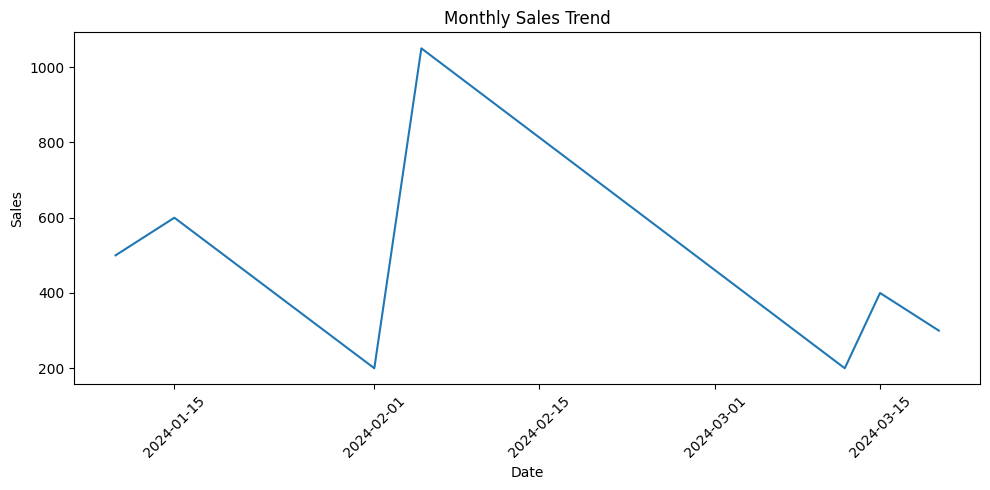

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example KPI: Monthly Sales Trend
monthly_sales = (retail_df_clean
                 .groupBy("TransactionDate")
                 .agg({"TotalAmount": "sum"})
                 .withColumnRenamed("sum(TotalAmount)", "MonthlySales")
                 .orderBy("TransactionDate"))

# Collect to driver for plotting
monthly_sales_pd = monthly_sales.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales_pd, x="TransactionDate", y="MonthlySales")
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Top-Selling Products by Total Sales**

<ipython-input-14-fada303d17b9>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products_pd, x="TotalSales", y="Product", palette="viridis")


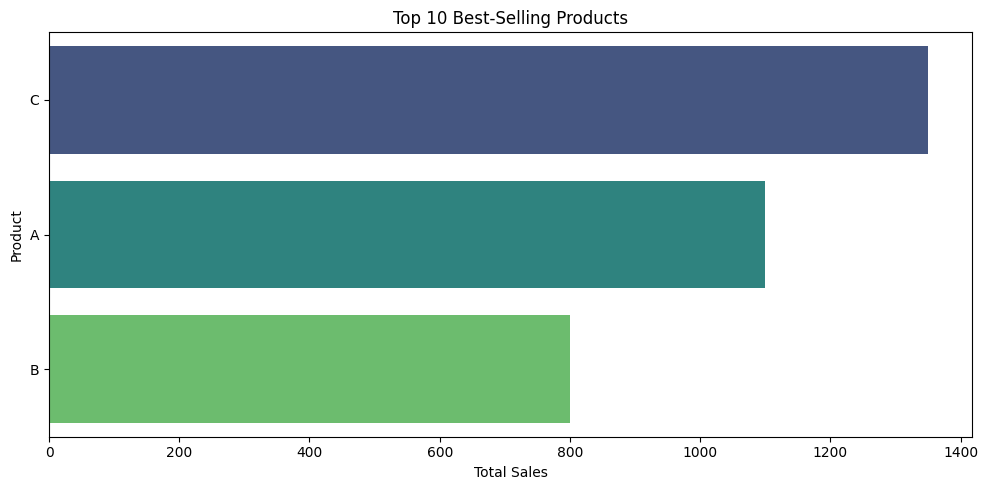

In [14]:
# Top-selling products
top_products = (retail_df_clean
                .groupBy("Product")
                .agg({"TotalAmount": "sum"})
                .withColumnRenamed("sum(TotalAmount)", "TotalSales")
                .orderBy("TotalSales", ascending=False)
                .limit(10))

# Convert to Pandas for plotting
top_products_pd = top_products.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=top_products_pd, x="TotalSales", y="Product", palette="viridis")
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Total Sales")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

**Sales Distribution by Store**

<ipython-input-15-7f2dc196ca5a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=store_sales_pd, x="StoreID", y="TotalSales", palette="mako")


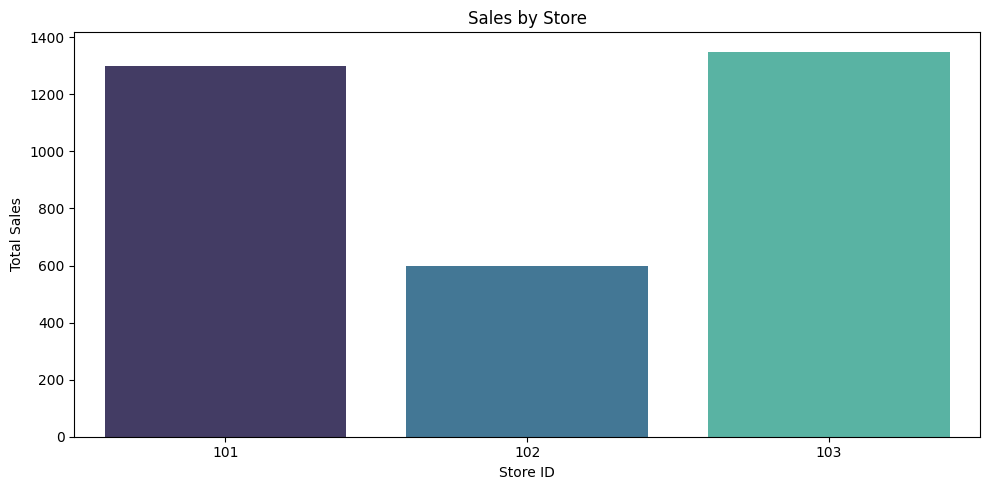

In [15]:
# Sales by store
store_sales = (retail_df_clean
               .groupBy("StoreID")
               .agg({"TotalAmount": "sum"})
               .withColumnRenamed("sum(TotalAmount)", "TotalSales")
               .orderBy("TotalSales", ascending=False))

# Convert to Pandas
store_sales_pd = store_sales.toPandas()

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=store_sales_pd, x="StoreID", y="TotalSales", palette="mako")
plt.title("Sales by Store")
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()